In [273]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from shapely import geometry
from pyproj import CRS
import math

### Open dataset and inspect variables

In [274]:
gcm_miroc = xr.open_dataset('notaro_MIROC_2040_2059.nc')

In [275]:
gcm_miroc

<xarray.Dataset>
Dimensions:  (iy: 86, jx: 111)
Coordinates:
  * iy       (iy) float32 -1.125e+03 -1.1e+03 -1.075e+03 ... 950.0 975.0 1e+03
  * jx       (jx) float32 -200.0 -175.0 -150.0 ... 2.5e+03 2.525e+03 2.55e+03
Data variables:
    xlat     (iy, jx) float32 ...
    rcm_map  |S1 ...
    xlon     (iy, jx) float32 ...
Attributes: (12/108)
    title:                                     Dynamical Downscaling for the ...
    institution:                               ICTP
    source:                                    RegCM Model output file
    Conventions:                               CF-1.4
    references:                                http://gforge.ictp.it/gf/proje...
    model_revision:                            tag 4.3.5.6
    ...                                        ...
    geospatial_lat_min:                        30.936655853032693
    geospatial_lat_max:                        54.10462175085763
    geospatial_lon_min:                        -100.23989055677092
    geospatial_lon_max:                        -60.51167692576732
    license:                                   Freely available
    History:                                   Translated to CF-1.0 Conventio...

In [276]:
gcm_miroc.grid_factor

0.6969437583315066

In [277]:
gcm_miroc.xlat

<xarray.DataArray 'xlat' (iy: 86, jx: 111)>
array([[34.799927, 34.805508, 34.81035 , ..., 31.218018, 31.147856, 31.077085],
       [35.02406 , 35.029663, 35.03452 , ..., 31.428381, 31.357956, 31.286919],
       [35.24832 , 35.25395 , 35.258823, ..., 31.638834, 31.568144, 31.49684 ],
       ...,
       [53.550213, 53.557907, 53.564575, ..., 48.665344, 48.57061 , 48.47509 ],
       [53.773808, 53.781532, 53.788227, ..., 48.870956, 48.77589 , 48.680035],
       [53.997242, 54.004993, 54.011715, ..., 49.07634 , 48.98094 , 48.88475 ]],
      dtype=float32)
Coordinates:
  * iy       (iy) float32 -1.125e+03 -1.1e+03 -1.075e+03 ... 950.0 975.0 1e+03
  * jx       (jx) float32 -200.0 -175.0 -150.0 ... 2.5e+03 2.525e+03 2.55e+03
Attributes:
    long_name:            Latitude on Cross Points
    standard_name:        latitude
    units:                degrees_north
    grid_mapping:         rcm_map
    _ChunkSizes:          [ 86 111]
    _CoordinateAxisType:  Lat

In [278]:
gcm_miroc.iy

<xarray.DataArray 'iy' (iy: 86)>
array([-1125., -1100., -1075., -1050., -1025., -1000.,  -975.,  -950.,  -925.,
        -900.,  -875.,  -850.,  -825.,  -800.,  -775.,  -750.,  -725.,  -700.,
        -675.,  -650.,  -625.,  -600.,  -575.,  -550.,  -525.,  -500.,  -475.,
        -450.,  -425.,  -400.,  -375.,  -350.,  -325.,  -300.,  -275.,  -250.,
        -225.,  -200.,  -175.,  -150.,  -125.,  -100.,   -75.,   -50.,   -25.,
           0.,    25.,    50.,    75.,   100.,   125.,   150.,   175.,   200.,
         225.,   250.,   275.,   300.,   325.,   350.,   375.,   400.,   425.,
         450.,   475.,   500.,   525.,   550.,   575.,   600.,   625.,   650.,
         675.,   700.,   725.,   750.,   775.,   800.,   825.,   850.,   875.,
         900.,   925.,   950.,   975.,  1000.], dtype=float32)
Coordinates:
  * iy       (iy) float32 -1.125e+03 -1.1e+03 -1.075e+03 ... 950.0 975.0 1e+03
Attributes:
    units:          km
    long_name:      y-coordinate in Cartesian system
    standard_name:  projection_y_coordinate

### Get projection info from `rcm_map` variable

In [279]:
gcm_miroc.rcm_map

<xarray.DataArray 'rcm_map' ()>
array(b'', dtype='|S1')
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    standard_parallel:              [36. 52.]
    longitude_of_central_meridian:  -97.0
    latitude_of_projection_origin:  45.0
    _CoordinateTransformType:       Projection
    _CoordinateAxisTypes:           GeoX GeoY

In [280]:
# define projection with cartopy
grid_crs_cartopy = ccrs.LambertConformal(central_longitude = gcm_miroc.rcm_map.longitude_of_central_meridian, central_latitude=gcm_miroc.rcm_map.latitude_of_projection_origin, standard_parallels = (gcm_miroc.rcm_map.standard_parallel[0],gcm_miroc.rcm_map.standard_parallel[1]))

In [281]:
grid_crs_cartopy

In [282]:
# convert to proj4 string using cartopy (need for geodataframe)
grid_crs_cartopy_proj4 = grid_crs_cartopy.proj4_init

In [330]:
grid_crs_cartopy_proj4

'+ellps=WGS84 +proj=lcc +lon_0=-97.0 +lat_0=45.0 +x_0=0.0 +y_0=0.0 +lat_1=36.0 +lat_2=52.0 +no_defs'

In [284]:
# define projection with pyproj, for comparison - DOESN'T READ IN lat_2 in R, with readOGR
grid_crs_pyproj = CRS(f'+proj=lcc +lat_0={gcm_miroc.rcm_map.latitude_of_projection_origin} + lon_0={gcm_miroc.rcm_map.longitude_of_central_meridian} + x_0=0.0 +y_0=0.0 + lat_1={gcm_miroc.rcm_map.standard_parallel[0]} + lat+2={gcm_miroc.rcm_map.standard_parallel[1]} +units=m')

In [329]:
grid_crs_pyproj

<Projected CRS: +proj=lcc +lat_0=45.0 + lon_0=-97.0 + x_0=0.0 +y_0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Reconstruct GCM grid using 'cartesian' projected coordinates, `iy` and `jx`
**NOTE:** this is the method that I belive is most robust.
See the end of [this discussion](https://github.com/USGS-R/lake-temperature-model-prep/issues/222)

In [286]:
#rows - latitudes
gcm_miroc.iy

<xarray.DataArray 'iy' (iy: 86)>
array([-1125., -1100., -1075., -1050., -1025., -1000.,  -975.,  -950.,  -925.,
        -900.,  -875.,  -850.,  -825.,  -800.,  -775.,  -750.,  -725.,  -700.,
        -675.,  -650.,  -625.,  -600.,  -575.,  -550.,  -525.,  -500.,  -475.,
        -450.,  -425.,  -400.,  -375.,  -350.,  -325.,  -300.,  -275.,  -250.,
        -225.,  -200.,  -175.,  -150.,  -125.,  -100.,   -75.,   -50.,   -25.,
           0.,    25.,    50.,    75.,   100.,   125.,   150.,   175.,   200.,
         225.,   250.,   275.,   300.,   325.,   350.,   375.,   400.,   425.,
         450.,   475.,   500.,   525.,   550.,   575.,   600.,   625.,   650.,
         675.,   700.,   725.,   750.,   775.,   800.,   825.,   850.,   875.,
         900.,   925.,   950.,   975.,  1000.], dtype=float32)
Coordinates:
  * iy       (iy) float32 -1.125e+03 -1.1e+03 -1.075e+03 ... 950.0 975.0 1e+03
Attributes:
    units:          km
    long_name:      y-coordinate in Cartesian system
    standard_name:  projection_y_coordinate

In [287]:
# columns - longitudes
gcm_miroc.jx

<xarray.DataArray 'jx' (jx: 111)>
array([-200., -175., -150., -125., -100.,  -75.,  -50.,  -25.,    0.,   25.,
         50.,   75.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,  275.,
        300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,  500.,  525.,
        550.,  575.,  600.,  625.,  650.,  675.,  700.,  725.,  750.,  775.,
        800.,  825.,  850.,  875.,  900.,  925.,  950.,  975., 1000., 1025.,
       1050., 1075., 1100., 1125., 1150., 1175., 1200., 1225., 1250., 1275.,
       1300., 1325., 1350., 1375., 1400., 1425., 1450., 1475., 1500., 1525.,
       1550., 1575., 1600., 1625., 1650., 1675., 1700., 1725., 1750., 1775.,
       1800., 1825., 1850., 1875., 1900., 1925., 1950., 1975., 2000., 2025.,
       2050., 2075., 2100., 2125., 2150., 2175., 2200., 2225., 2250., 2275.,
       2300., 2325., 2350., 2375., 2400., 2425., 2450., 2475., 2500., 2525.,
       2550.], dtype=float32)
Coordinates:
  * jx       (jx) float32 -200.0 -175.0 -150.0 ... 2.5e+03 2.525e+03 2.55e+03
Attributes:
    units:          km
    long_name:      x-coordinate in Cartesian system
    standard_name:  projection_x_coordinate

In [288]:
# check grid cell vertical gap
# 25km, as expected
gcm_miroc.iy[1] - gcm_miroc.iy[0]

<xarray.DataArray 'iy' ()>
array(25., dtype=float32)

In [289]:
# check grid cell horizontal gap
# 25km, as expected
gcm_miroc.jx[1] - gcm_miroc.jx[0]

<xarray.DataArray 'jx' ()>
array(25., dtype=float32)

##### Make bounding box

In [290]:
# make bounding polygon with meters lat lons (raw cartesian coords in km)
bb_point1 = geometry.Point(gcm_miroc.jx[0]*1000,gcm_miroc.iy[0]*1000)
bb_point2 = geometry.Point(gcm_miroc.jx[-1]*1000,gcm_miroc.iy[0]*1000)
bb_point3 = geometry.Point(gcm_miroc.jx[-1]*1000,gcm_miroc.iy[-1]*1000)
bb_point4 = geometry.Point(gcm_miroc.jx[0]*1000,gcm_miroc.iy[-1]*1000)
bb_pointList = [bb_point1, bb_point2, bb_point3, bb_point4, bb_point1]
bb_poly = geometry.Polygon([[p.x, p.y] for p in bb_pointList])

In [350]:
bounding_box = gpd.GeoDataFrame(crs = grid_crs_cartopy_proj4, geometry=[bb_poly])

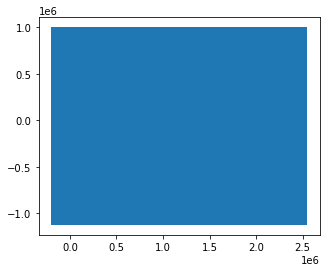

In [351]:
bounding_box.plot()

In [352]:
bounding_box.crs

<Projected CRS: +proj=lcc +ellps=WGS84 +lon_0=-97.0 +lat_0=45.0 +x ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [353]:
bounding_box.to_file('gcm_bounding_box.shp')

##### Make cell polygons

In [295]:
cell_poly_list = []
for i in range(0, (len(gcm_miroc.iy)-1)):
    for j in range(0, (len(gcm_miroc.jx)-1)):
        cell_point1 = geometry.Point(gcm_miroc.jx[j]*1000,gcm_miroc.iy[i]*1000)
        cell_point2 = geometry.Point(gcm_miroc.jx[j]*1000,gcm_miroc.iy[i+1]*1000)
        cell_point3 = geometry.Point(gcm_miroc.jx[j+1]*1000,gcm_miroc.iy[i+1]*1000)
        cell_point4 = geometry.Point(gcm_miroc.jx[j+1]*1000,gcm_miroc.iy[i]*1000)
        cell_point_list = [cell_point1, cell_point2, cell_point3, cell_point4, cell_point1]
        cell_poly = geometry.Polygon([[p.x, p.y] for p in cell_point_list])
        cell_poly_list.append(cell_poly)

In [339]:
grid_cells_gdf = gpd.GeoDataFrame(crs = grid_crs_cartopy_proj4, geometry=cell_poly_list) #grid_crs_pyproj
grid_cells_gdf['cell_no'] = grid_cells_gdf.index + 1

In [340]:
grid_cells_gdf.head()

,geometry,cell_no
0,"POLYGON ((-200000.000 -1125000.000, -200000.00...",1
1,"POLYGON ((-175000.000 -1125000.000, -175000.00...",2
2,"POLYGON ((-150000.000 -1125000.000, -150000.00...",3
3,"POLYGON ((-125000.000 -1125000.000, -125000.00...",4
4,"POLYGON ((-100000.000 -1125000.000, -100000.00...",5


In [341]:
grid_cells_gdf.to_file('gcm_grid_cells.shp')

In [299]:
cell_subset = grid_cells_gdf.loc[(grid_cells_gdf['cell_no'] >= 111) & (grid_cells_gdf['cell_no'] < (111+110))]

In [300]:
cell_subset.head()

,geometry,cell_no
110,"POLYGON ((-200000.000 -1100000.000, -200000.00...",111
111,"POLYGON ((-175000.000 -1100000.000, -175000.00...",112
112,"POLYGON ((-150000.000 -1100000.000, -150000.00...",113
113,"POLYGON ((-125000.000 -1100000.000, -125000.00...",114
114,"POLYGON ((-100000.000 -1100000.000, -100000.00...",115


##### plot cell polygons and coordinates

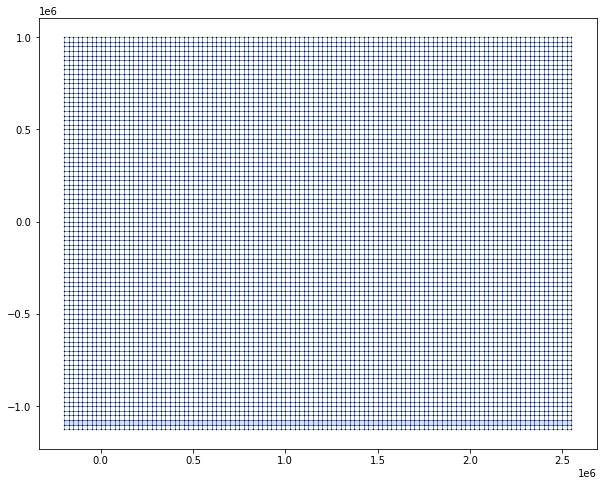

In [328]:
fig, ax = plt.subplots(figsize=(10,10))

grid_cells_gdf.plot(ax=ax, alpha=0.5, facecolor='None', edgecolor='royalblue')
cell_subset.plot(ax=ax, alpha=0.5, facecolor='lightsteelblue', edgecolor='royalblue')

i_range = range(0,len(gcm_miroc.iy))
j_range = range(0,len(gcm_miroc.jx))

for i in i_range:
    for j in j_range:
        ax.scatter(gcm_miroc.jx[j]*1000, gcm_miroc.iy[i]*1000, color='black', linewidth=0.4, marker='o', s=1)

### get centroids of grid cells

In [342]:
grid_cell_centroids_gdf = gpd.GeoDataFrame(crs = grid_crs_cartopy_proj4, geometry=grid_cells_gdf.centroid)
grid_cell_centroids_gdf['cell_no'] = grid_cell_centroids_gdf.index + 1

In [343]:
grid_cell_centroids_gdf.head()

,geometry,cell_no
0,POINT (-187500.000 -1112500.000),1
1,POINT (-162500.000 -1112500.000),2
2,POINT (-137500.000 -1112500.000),3
3,POINT (-112500.000 -1112500.000),4
4,POINT (-87500.000 -1112500.000),5


In [344]:
grid_cell_centroids_gdf.to_file('gcm_grid_cell_centroids.shp')

### make grid tiles

In [305]:
n_columns_coordinates = len(gcm_miroc.jx)-1
n_rows_coordinates = len(gcm_miroc.iy)-1

In [306]:
tile_height = 10
tile_width = 10

In [307]:
width_remainder = n_columns_coordinates % tile_width
height_remainder = n_rows_coordinates % tile_height

In [308]:
n_columns_tiles = math.floor(n_columns_coordinates/tile_width) if width_remainder == 0 else math.floor(n_columns_coordinates/tile_width) + 1

In [309]:
n_rows_tiles = math.floor(n_rows_coordinates/tile_height) if height_remainder == 0 else math.floor(n_rows_coordinates/tile_height) + 1

In [310]:
n_columns_tiles

11

In [311]:
n_rows_tiles

9

In [312]:
width_remainder

0

In [313]:
height_remainder

5

In [314]:
n_tiles = n_columns_tiles * n_rows_tiles

In [315]:
n_tiles

99

In [316]:
def get_tile_index_breaks(n_dir_tiles, dim_remainder, tile_dim):
    tile_breaks = []
    # for all of the tiles in that dimension (row/columns)
    for i in range(0,(n_dir_tiles+1)):
        # if all tiles are the full specified width/height
        if dim_remainder == 0:
            # place the break at the tile dimension (width/height) * 
            # the index of the tile in that dimension
            # plus one, to get to the edge of that polygon
            tile_breaks.append(i*tile_dim)
        # if the last tile will be less than the full width/height
        else:
            # if we're not yet on the last tile
            if i < n_dir_tiles:
                # place the break at the tile dimension (width/height) * 
                # the index of the tile in that dimension
                # plus one, to get to the edge of that polygon
                tile_breaks.append(i*tile_dim)
            # otherwise, if this is the last tile and that tile will be 
            # less than the full width/height
            else:
                # place the break at the tile dimension (width/height) * 
                # the index of the PREVIOUS tile in that dimension
                # PLUS the remaining width/height + # plus one, to 
                # get to the edge of that polygon
                tile_breaks.append(((i-1)*tile_dim)+dim_remainder)
    
    # return the list of breaks
    return(tile_breaks)

In [317]:
tile_column_index_breaks = get_tile_index_breaks(n_columns_tiles, width_remainder, tile_width)

In [318]:
tile_column_index_breaks

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

In [319]:
tile_row_index_breaks = get_tile_index_breaks(n_rows_tiles, height_remainder, tile_height)

In [320]:
tile_row_index_breaks

[0, 10, 20, 30, 40, 50, 60, 70, 80, 85]

In [321]:
tile_poly_list = []
for i in range(0, (len(tile_row_index_breaks)-1)):
    for j in range(0, (len(tile_column_index_breaks)-1)):
        tile_point1 = geometry.Point(gcm_miroc.jx[tile_column_index_breaks[j]]*1000,gcm_miroc.iy[tile_row_index_breaks[i]]*1000)
        tile_point2 = geometry.Point(gcm_miroc.jx[tile_column_index_breaks[j]]*1000,gcm_miroc.iy[tile_row_index_breaks[i+1]]*1000)
        tile_point3 = geometry.Point(gcm_miroc.jx[tile_column_index_breaks[j+1]]*1000,gcm_miroc.iy[tile_row_index_breaks[i+1]]*1000)
        tile_point4 = geometry.Point(gcm_miroc.jx[tile_column_index_breaks[j+1]]*1000,gcm_miroc.iy[tile_row_index_breaks[i]]*1000)
        tile_point_list = [tile_point1, tile_point2, tile_point3, tile_point4, tile_point1]
        tile_poly = geometry.Polygon([[p.x, p.y] for p in tile_point_list])
        tile_poly_list.append(tile_poly)

In [345]:
grid_tiles_gdf = gpd.GeoDataFrame(crs = grid_crs_cartopy_proj4, geometry=tile_poly_list)
grid_tiles_gdf['tile_no'] = grid_tiles_gdf.index+1

In [346]:
grid_tiles_gdf

,geometry,tile_no
0,"POLYGON ((-200000.000 -1125000.000, -200000.00...",1
1,"POLYGON ((50000.000 -1125000.000, 50000.000 -8...",2
2,"POLYGON ((300000.000 -1125000.000, 300000.000 ...",3
3,"POLYGON ((550000.000 -1125000.000, 550000.000 ...",4
4,"POLYGON ((800000.000 -1125000.000, 800000.000 ...",5
...,...,...
94,"POLYGON ((1300000.000 875000.000, 1300000.000 ...",95
95,"POLYGON ((1550000.000 875000.000, 1550000.000 ...",96
96,"POLYGON ((1800000.000 875000.000, 1800000.000 ...",97
97,"POLYGON ((2050000.000 875000.000, 2050000.000 ...",98


In [347]:
grid_tiles_gdf.to_file('gcm_grid_tiles.shp')

In [325]:
tile_subset = grid_tiles_gdf.loc[(grid_tiles_gdf['tile_no'] >= 23) & (grid_tiles_gdf['tile_no'] < 34)]

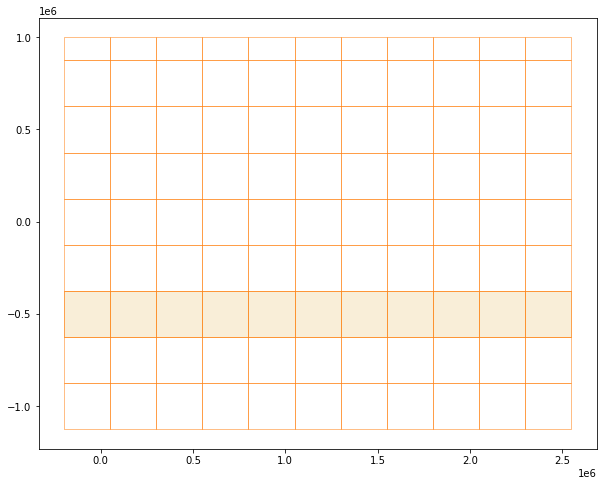

In [348]:
fig, ax = plt.subplots(figsize=(10,10))

grid_tiles_gdf.plot(ax=ax, alpha=0.5, facecolor='None', edgecolor='C1')
tile_subset.plot(ax=ax, alpha=0.5, facecolor='wheat', edgecolor='C1')

i_range = range(0,len(gcm_miroc.iy))
j_range = range(0,len(gcm_miroc.jx))

# for i in i_range:
#     for j in j_range:
#         ax.scatter(gcm_miroc.jx[j]*1000, gcm_miroc.iy[i]*1000, color='black', linewidth=0.4, marker='o', s=1)

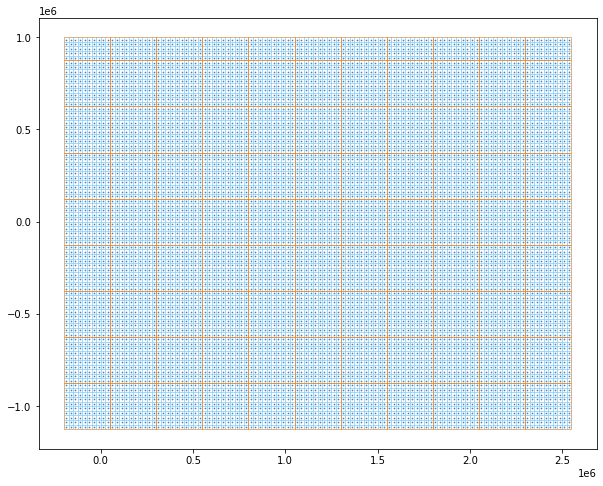

In [349]:
fig, ax = plt.subplots(figsize=(10,10))

grid_cells_gdf.plot(ax=ax, alpha=0.5, facecolor='None', edgecolor='lightskyblue')
grid_cell_centroids_gdf.plot(ax=ax, color='steelblue', marker='o', markersize=0.5)
grid_tiles_gdf.plot(ax=ax, alpha=0.5, facecolor='None', edgecolor='C1')

i_range = range(0,len(gcm_miroc.iy))
j_range = range(0,len(gcm_miroc.jx))

# for i in i_range:
#     for j in j_range:
#         ax.scatter(gcm_miroc.jx[j]*1000, gcm_miroc.iy[i]*1000, color='black', linewidth=0.4, marker='o', s=1)

### For comparison, reconstruct grid using `xlat` and `xlon` instead (unprojected dd lat/long of grid cross points)
**Note:** This results in a curved grid, as is expected if the 2D `xlat` and `xlon` arrays represent the unprojected decimal degree cross points of a grid that was constructed in a custom lambert conformal conic projection. See [the discussion at the end of this issue](https://github.com/USGS-R/lake-temperature-model-prep/issues/222) for screen shots and my notes.

In [26]:
# get shape of xlat (rows, columns)
gcm_miroc['xlat'].shape

(86, 111)

In [27]:
# get shape of xlon (rows, columns)
gcm_miroc['xlon'].shape

(86, 111)

##### Make bounding box (will only align at corners, b/c grid built w/ xlat xlon curved - lat and long vary along grid lines)

In [28]:
# make bounding polygon with dd lat lons - won't match xlat xlon grid cells b/c not curved
p1_dd = geometry.Point(gcm_miroc['xlon'][0,0],gcm_miroc['xlat'][0,0])
p2_dd = geometry.Point(gcm_miroc['xlon'][0,-1],gcm_miroc['xlat'][0,-1])
p3_dd = geometry.Point(gcm_miroc['xlon'][-1,-1],gcm_miroc['xlat'][-1,-1])
p4_dd = geometry.Point(gcm_miroc['xlon'][-1,0],gcm_miroc['xlat'][-1,0])
pointList_dd = [p1_dd, p2_dd, p3_dd, p4_dd, p1_dd]
poly_dd = geometry.Polygon([[p.x, p.y] for p in pointList_dd])

In [29]:
bounding_box_dd = gpd.GeoDataFrame(crs='EPSG:4326', geometry=[poly_dd]) # wgs84: crs='EPSG:4326' nad83: crs='EPSG:4269'

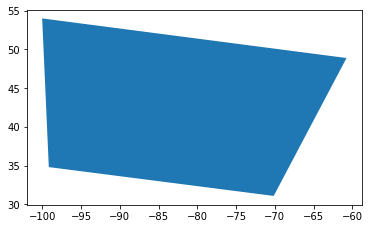

In [30]:
bounding_box_dd.plot()

In [31]:
bounding_box_dd.to_file('gcm_bounding_box_DD_wgs84.shp')

##### Make cell grid

In [32]:
poly_list_dd = []
# plt.plot(poly)
# for i, j in zip(i_range, j_range):
for i in range(0, (gcm_miroc['xlon'].shape[0] - 1)):
    for j in range(0, (gcm_miroc['xlon'].shape[1] - 1)):
        # make bounding polygon with dd lat lons
        point1_dd = geometry.Point(gcm_miroc['xlon'][i,j],gcm_miroc['xlat'][i,j])
        point2_dd = geometry.Point(gcm_miroc['xlon'][i,j+1],gcm_miroc['xlat'][i,j+1])
        point3_dd = geometry.Point(gcm_miroc['xlon'][i+1,j+1],gcm_miroc['xlat'][i+1,j+1])
        point4_dd = geometry.Point(gcm_miroc['xlon'][i+1,j],gcm_miroc['xlat'][i+1,j])
        pointList_dd = [point1_dd, point2_dd, point3_dd, point4_dd, point1_dd]
        grid_poly_dd = geometry.Polygon([[p.x, p.y] for p in pointList_dd])
        poly_list_dd.append(grid_poly_dd)

In [33]:
gdf_grid_cells_dd = gpd.GeoDataFrame(crs='EPSG:4326', geometry=poly_list_dd) # wgs84: crs='EPSG:4326' nad83: crs='EPSG:4269'

In [34]:
gdf_grid_cells_dd.to_file('gcm_grid_cells_DD_wgs84.shp')

##### Plot grid cells constructed from xlat xlon variables

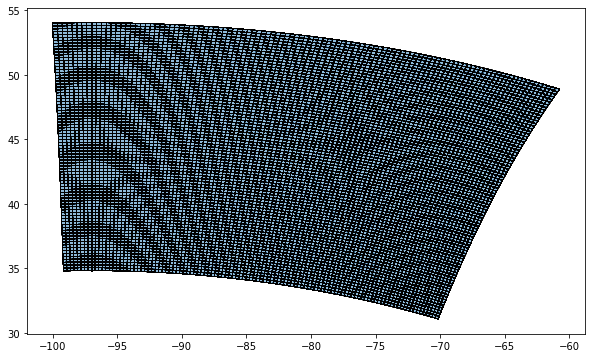

In [35]:
fig, ax = plt.subplots(figsize=(10,10))

gdf_grid_cells_dd.plot(ax=ax, alpha=0.5)

i_range = range(0,gcm_miroc['xlon'].shape[0])
j_range = range(0,gcm_miroc['xlon'].shape[1])

for i in i_range:
    for j in j_range:
        # plot latitudinal gridlines - plot across each row
        ax.plot(gcm_miroc['xlon'][i,j_range], gcm_miroc['xlat'][i,j_range], color='black', linewidth=0.4)
        # plot longitudinal gridlines - plot across each column
        ax.plot(gcm_miroc['xlon'][i_range,j], gcm_miroc['xlat'][i_range,j], color='black', linewidth=0.4)
# plt.scatter(gcm_miroc['xlon'][i_range,j_range], gcm_miroc['xlat'][i_range,j_range], color='black',s=4)
